What happens when we pass a long binary input string through multiple linear systems with different $\tau$'s?

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_font_size

DT = .005

R_BIN = np.linspace(0, 1, 17)

np.random.seed(10)

We start with a binary input stream containing $n$ segments of length $\Delta T$ with $n \Delta T = T$. There are $2^n$ possible input "strings", as each time window can be either $\{0, 1\}$.

In [2]:
def s2cur(s, step):
    n = len(s)
    
    t = np.arange(0, n*step, DT)
    cur = np.zeros(len(t))
    
    istep = int(round(step/DT))
    
    for istart in s.nonzero()[0]*istep:
        cur[istart:istart+istep] = 1
        
    return cur

In [3]:
n = 1024
step = 1/16
q = .5

n_in = 50000
tau_1 = .087
taus = [.001, .05, .07, tau_1, .2, 1, 2, 4]

ss = np.concatenate([np.random.binomial(1, q, (n_in, n)), np.ones((1, n), bool)])
curs = np.array([s2cur(s, step=step) for s in ss])
t = np.arange(len(curs[0])) * DT

In [4]:
h_1 = np.exp(-t/tau_1)
r_1 = np.array([h_1[::-1]@cur for cur in curs])
r_1 /= np.max(r_1)

rs = []

for tau in taus:
    sys.stdout.write('.')
    h = np.exp(-t/tau)
    r = np.array([h[::-1]@cur for cur in curs])
    r /= np.max(r)
    rs.append(r)

........

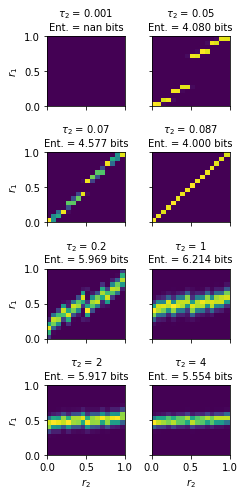

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(3.5, 7), sharex=True, sharey=True, tight_layout=True)

for cax, (ax, tau_2) in enumerate(zip(axs.flatten(), taus)):
    r_2 = rs[cax]
    
    cts = np.histogram2d(r_1, r_2, bins=[R_BIN, R_BIN])[0]
    p = cts / cts.sum()
    ent = stats.entropy(p.flatten(), base=2)
    
    ax.hist2d(r_1, r_2, bins=[R_BIN, R_BIN])
    title = fr'$\tau_2$ = {tau_2}' + '\n' + fr'Ent. = {ent:.3f} bits'
    ax.set_title(title)
    
for ax in axs[-1, :]:
    ax.set_xlabel(r'$r_2$')
    
for ax in axs[:, 0]:
    ax.set_ylabel(r'$r_1$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_1_r_2_tau_2_sweep.pdf')

In [6]:
n_bins = [17, 33, 65, 129, 257]

taus_2 = np.logspace(-3, .6021, 121)
ents_all = np.nan * np.zeros((len(n_bins), len(taus_2)))

for ctau, tau_2 in enumerate(taus_2):
    sys.stdout.write('.')
    h_2 = np.exp(-t/tau_2)
    r_2 = np.array([h_2[::-1]@cur for cur in curs])
    r_2 /= np.max(r_2)
 
    for cn_bin, n_bin in enumerate(n_bins):
        r_bin = np.linspace(0, 1, n_bin+1)
        cts = np.histogram2d(r_1, r_2, bins=[r_bin, r_bin])[0]
        p = cts / cts.sum()

        ents_all[cn_bin, ctau] = stats.entropy(p.flatten(), base=2)
        
print('')

taus_2_zoom = np.linspace(.07, .1, 61)
ents_all_zoom = np.nan * np.zeros((len(n_bins), len(taus_2_zoom)))

for ctau, tau_2 in enumerate(taus_2_zoom):
    sys.stdout.write('.')
    h_2 = np.exp(-t/tau_2)
    r_2 = np.array([h_2[::-1]@cur for cur in curs])
    r_2 /= np.max(r_2)
 
    for cn_bin, n_bin in enumerate(n_bins):
        r_bin = np.linspace(0, 1, n_bin+1)
        cts = np.histogram2d(r_1, r_2, bins=[r_bin, r_bin])[0]
        p = cts / cts.sum()

        ents_all_zoom[cn_bin, ctau] = stats.entropy(p.flatten(), base=2)

.........................................................................................................................
.............................................................

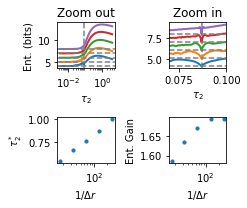

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3), tight_layout=True)
axs[0, 0].axvline(tau_1, ls='--', color='gray')

tau_2_stars = []
ents_max = []

for n_bin, ents in zip(n_bins, ents_all):
    tau_2_stars.append(taus_2[np.nanargmax(ents)])
    ents_max.append(np.nanmax(ents))

    axs[0, 0].semilogx(taus_2, ents, lw=2)
    axs[0, 0].axhline(np.log2(n_bin), ls='--', color='gray')
    
axs[0, 0].set_xticks([.01, 1])
axs[0, 0].set_xlabel(r'$\tau_2$')
axs[0, 0].set_ylabel('Ent. (bits)')
axs[0, 0].set_title('Zoom out')

axs[0, 1].axvline(tau_1, ls='--', color='gray')

for n_bin, ents in zip(n_bins, ents_all_zoom):

    axs[0, 1].plot(taus_2_zoom, ents, lw=2)
    axs[0, 1].axhline(np.log2(n_bin), ls='--', color='gray')

axs[0, 1].set_xlim(.07, .1)
axs[0, 1].set_xlabel(r'$\tau_2$')
axs[0, 1].set_title('Zoom in')

axs[1, 0].scatter(n_bins, tau_2_stars, s=10)
axs[1, 0].set_xscale('log')

axs[1, 0].set_xlabel(r'$1/\Delta r$')
axs[1, 0].set_ylabel(r'$\tau_2^*$')

axs[1, 1].scatter(n_bins, np.array(ents_max)/np.log2(n_bins), s=10)
axs[1, 1].set_xscale('log')

axs[1, 1].set_xlabel(r'$1/\Delta r$')
axs[1, 1].set_ylabel('Ent. Gain')

fig.savefig('plots/ent_tau_2_delta_r.pdf')

In [8]:
ents_max

[6.484342572197705,
 8.243137878973036,
 10.059023077721465,
 11.876571861710731,
 13.557834802990971]

In [9]:
tau_2_stars

[0.5390046352718897,
 0.6632007367493543,
 0.7615176962806192,
 0.8744097670803829,
 1.0040376533598205]

What is the timescale of third best neural variable to add?

In [10]:
n_bin = n_bins[0]
r_bin = np.linspace(0, 1, n_bin+1)

tau_1 = .087
h_1 = np.exp(-t/tau_1)
r_1 = np.array([h_1[::-1]@cur for cur in curs])
r_1 /= np.max(r_1)

tau_2 = .5776
h_2 = np.exp(-t/tau_2)
r_2 = np.array([h_2[::-1]@cur for cur in curs])
r_2 /= np.max(r_2)

taus = np.logspace(-3, .9, 181)
ents_3 = np.nan * np.zeros(len(taus))

for ctau_3, tau_3 in enumerate(taus):
    sys.stdout.write('.')
    h_3 = np.exp(-t/tau_3)
    r_3 = np.array([h_3[::-1]@cur for cur in curs])
    r_3 /= np.max(r_3)
    
    cts = np.histogramdd(np.array([r_1, r_2, r_3]).T, bins=3*[r_bin])[0]
    
    p = cts / cts.sum()
    
    ents_3[ctau_3] = stats.entropy(p.flatten(), base=2)

.....................................................................................................................................................................................

In [11]:
print('Best tau_3 =', taus[np.nanargmax(ents_3)])
print('Ent =', np.nanmax(ents_3))

Best tau_3 = 2.6505337179010797
Ent = 7.8205881540163675


In [12]:
tau_1 = .087
h_1 = np.exp(-t/tau_1)
r_1 = np.array([h_1[::-1]@cur for cur in curs])
r_1 /= np.max(r_1)

tau_2 = .5776
h_2 = np.exp(-t/tau_2)
r_2 = np.array([h_2[::-1]@cur for cur in curs])
r_2 /= np.max(r_2)

tau_3 = 2.522
h_3 = np.exp(-t/tau_3)
r_3 = np.array([h_3[::-1]@cur for cur in curs])
r_3 /= np.max(r_3)

taus_4 = np.logspace(-3, 1.2, 181)

ents_4 = np.nan * np.zeros(len(taus_4))

for ctau_4, tau_4 in enumerate(taus_4):
    sys.stdout.write('.')
    h_4 = np.exp(-t/tau_4)
    r_4 = np.array([h_4[::-1]@cur for cur in curs])
    r_4 /= np.max(r_4)
    
    cts = np.histogramdd(np.array([r_1, r_2, r_3, r_4]).T, bins=4*[r_bin])[0]
    
    p = cts / cts.sum()
    
    ents_4[ctau_4] = stats.entropy(p.flatten(), base=2)

.....................................................................................................................................................................................

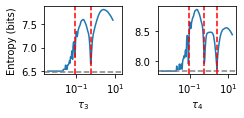

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(3.5, 1.75), tight_layout=True, sharex=True)

axs[0].semilogx(taus, ents_3)
axs[0].axhline(ents_max[0], color='gray', ls='--')
axs[0].axvline(tau_1, color='r', ls='--')
axs[0].axvline(tau_2, color='r', ls='--')
axs[0].set_xlabel(r'$\tau_3$')
axs[0].set_ylabel('Entropy (bits)')

axs[1].semilogx(taus_4, ents_4)
axs[1].axhline(np.nanmax(ents_3), color='gray', ls='--')
axs[1].axvline(tau_1, color='r', ls='--')
axs[1].axvline(tau_2, color='r', ls='--')
axs[1].axvline(tau_3, color='r', ls='--')
axs[1].set_xlabel(r'$\tau_4$')

set_font_size(axs, 10)
fig.savefig('plots/ent_vs_tau_3_tau_4.pdf')

In [14]:
print('Best tau_4 =', taus_4[np.nanargmax(ents_4)])
print('Ent =', np.nanmax(ents_4))

Best tau_4 = 0.22733518989206314
Ent = 8.873417729870551
